**This is tested on tensorflow-gpu = 1.13.1**

This notebook aims to demonstrate the power of Seq2Seq modelling with RNN's (and its variants like LSTM / GRU) where the length input sequences doesn't match with the length of output sequences. 

Canonical usecases are:

1. Machine Translation
2. Text Summarisation


But for the purposes of this notebook we will be using a contrived dataset. We will translating natural langauge english sentences mentioning some form of time to their coressponding numerical versions. For instance


*   **four minutes past seven evening**	should translate as **19:04**
*   **quarter past noon**	should translate as **12:15**
*   **quarter past night**	should translate as **00:15**



But nevertheless you will learn both the advantages and disadvantages of a EncoderDecoder Model. We will also look at the motivation for attention mechanism in the EncoderDecoder Model.






In [0]:
# Start by importing all the things we'll need.
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, CuDNNLSTM, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K

import unicodedata
import re
import numpy as np
import os
import time
import shutil

In [0]:
 # Synthetic Training and Test data
import random

def generate_data(hour,  minute, sentence=''):

    special  = [15,30]
    suffix = ""

    dictionary = {1:"one", 2:"two", 3:"three", 4:"four", 5:"five", 6:"six", 7:"seven", 8:"eight", 9:"nine", 10:"ten", 11:"eleven", 12:"twelve", 13:"thirteen", 
                  14:"fourteen", 16:"sixteen", 17:"seventeen", 18:"eighteen", 19:"nineteen", 20:"twenty", 30:"thirty",
                  40:"forty", 50:"fifty"}
    result = ""
    if minute == 15:
        result= "quarter past"
    elif minute == 30:
        result= "half past"    
    elif minute == 0:
        pass
    else:

        if minute in dictionary:
            result = dictionary[minute] + " minutes past"
        else:        
            minute1 = int(str(minute // 10 ) + "0") 
            minute2 = minute % 10
            result = dictionary[minute1] + ' ' +  dictionary[minute2] + " minutes past"

    if hour == 0:
        suffix = "mid night"
    elif hour >= 1 and hour <= 11:
        suffix = "morning"
    elif hour == 12:
        suffix = "noon"
    elif hour > 12 and hour <=16:   
        suffix = "after noon"
    elif hour > 16 and hour <=19:   
        suffix = "evening"
    elif hour > 20 and hour <=23:   
        suffix = "night"

    save_hour = hour            
    if hour > 12:
        hour = hour - 12

    if hour > 0:
        # Lets introduce some variation in the way how hours an sufffixes are formed, just for randomness
        if hour % 2 == 0:
           result = result + " " + dictionary[hour]+ " in the " + suffix  
        else:    
           result = result + " " + dictionary[hour]+ " " + suffix          
    else:
        result = result + " " + suffix  

    return save_hour, minute, result


def create_dataset(num_examples=20000):  
  output = []
  i = 0
  while i < num_examples:
      data = []
      hour = random.randint(0,23)
      minute = random.randint(0,59)
      sent = random.randint(0,3)
      hour, minute, result = generate_data(hour, minute)
      inwords = result
      data.append('<start> ' + inwords + ' <end>')
      data.append('<start> ' + str(hour) + " : " + str(minute) + ' <end>')
      i += 1
      output.append(data)
  print("Dataset prepared with prefix and suffixes for teacher forcing technique")
  dummy_df = pd.DataFrame(output, columns=['input','output'])
  return output, dummy_df




In [0]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx["<pad>"] = 0
        self.idx2word[0] = "<pad>"
        for i,word in enumerate(self.vocab):
            self.word2idx[word] = i + 1
            self.idx2word[i+1] = word

def max_length(t):
    return max(len(i) for i in t)

def load_dataset(num_examples):
    pairs,df = create_dataset(num_examples)
    #print(pairs[10])
    #print(len(pairs))
    out_lang = LanguageIndex(sp for en, sp in pairs)
    in_lang = LanguageIndex(en for en, sp in pairs)
    input_data = [[in_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    output_data = [[out_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]

    max_length_in, max_length_out = max_length(input_data), max_length(output_data)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_data, maxlen=max_length_in, padding="post")
    output_data = tf.keras.preprocessing.sequence.pad_sequences(output_data, maxlen=max_length_out, padding="post")
    return input_data, output_data, in_lang, out_lang, max_length_in, max_length_out, df

In [51]:
num_examples = 50000 # Partial set for faster training
input_data, teacher_data, input_lang, target_lang, len_input, len_target, df = load_dataset(num_examples)


target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# Shuffle all of the data in unison. This training set has the longest (e.g. most complicated) data at the end,
# so a simple Keras validation split will be problematic if not shuffled.

p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]

BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 300
units = 128
vocab_in_size = len(input_lang.word2idx)
vocab_out_size = len(target_lang.word2idx)
df.head()


Dataset prepared with prefix and suffixes for teacher forcing technique


,input,output
0,<start> eight minutes past three after noon <end>,<start> 15 : 8 <end>
1,<start> eleven minutes past seven morning <end>,<start> 7 : 11 <end>
2,<start> three minutes past five morning <end>,<start> 5 : 3 <end>
3,<start> twenty one minutes past eleven morning...,<start> 11 : 21 <end>
4,<start> fifty one minutes past three after noo...,<start> 15 : 51 <end>


In [53]:
# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)

# Use this if you dont need Bidirectional LSTM
# encoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
# encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))

encoder_lstm = Bidirectional(CuDNNLSTM(units=units, return_sequences=True, return_state=True))
encoder_outputs, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])
encoder_states = [state_h, state_c]

# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=units*2, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers added to this model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
# Drop-out is added in the dense layers to help mitigate overfitting in this part of the model. Astute developers
# may want to add the same mechanism inside the LSTMs.
decoder_out = decoder_d2(Dropout(rate=.4)(decoder_d1(Dropout(rate=.4)(decoder_lstm_out))))

# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
#  encoder_inputs=[batch,encoded_words] from input language (English)
#  decoder_inputs=[batch,encoded_words] from output language (Spanish). This is the "teacher tensor".
#  decoder_out=[batch,encoded_words] from output language (Spanish). This is the "target tensor".
model = Model([encoder_inputs, decoder_inputs], decoder_out)
# We'll use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
#  Adam is used because it's, well, the best.
model.compile(optimizer=tf.train.AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 11, 300)      11400       input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 11, 256), (N 440320      embedding_4[0][0]                
__________________________________________________________________________________________________
embedding_

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 3s 81us/sample - loss: 0.0013 - sparse_categorical_accuracy: 0.9996 - val_loss: 6.4224e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/15
40000/40000 [==============================] - 3s 78us/sample - loss: 0.0017 - sparse_categorical_accuracy: 0.9995 - val_loss: 1.4393e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/15
40000/40000 [==============================] - 3s 78us/sample - loss: 0.0036 - sparse_categorical_accuracy: 0.9991 - val_loss: 6.6231e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/15
40000/40000 [==============================] - 3s 79us/sample - loss: 0.0011 - sparse_categorical_accuracy: 0.9997 - val_loss: 6.4520e-06 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/15
40000/40000 [==============================] - 3s 78us/sample - loss: 0.0013 - sparse_categorical_accuracy: 0.9996 - val_loss: 6.3670e-06 - val_sparse_categorical_accuracy: 1.

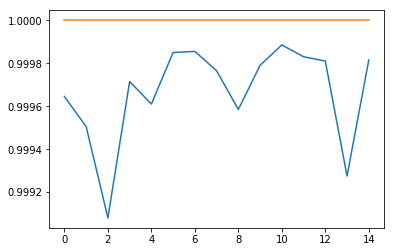

In [57]:
# Note, we use 20% of our data for validation.
epochs = 15
history = model.fit([input_data, teacher_data], target_data,
                 batch_size=BATCH_SIZE,
                 epochs=epochs,
                 validation_split=0.2)

# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['sparse_categorical_accuracy'], label="Training loss")
plt.plot(history.history['val_sparse_categorical_accuracy'], label="Validation loss")
plt.show()

In [0]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).
inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])

In [0]:
# Converts the given sentence (just a string) into a vector of word IDs
# using the language specified. This can be used for either the input (English)
# or target (Spanish) languages.
# Output is 1-D: [timesteps/words]
def sentence_to_vector(sentence, lang):
    #pre = preprocess_sentence(sentence)
    pre = sentence
    vec = np.zeros(len_input)
    sentence_list = [lang.word2idx[s] for s in pre.split(' ')]
    for i,w in enumerate(sentence_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
# return a translated string.
def translate(input_sentence, infenc_model, infmodel, attention=False):
    sv = sentence_to_vector(input_sentence, input_lang)
    # Reshape so we can use the encoder model. New shape=[samples,sequence length]
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = target_lang.word2idx["<start>"]
    stop_vec = target_lang.word2idx["<end>"]
    # We will continuously feed cur_vec as an input into the decoder to produce the next word,
    # which will be assigned to cur_vec. Start it with "<start>".
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "<start>"
    output_sentence = ""
    # Start doing the feeding. Terminate when the model predicts an "<end>" or we reach the end
    # of the max target language sentence length.
    while cur_word != "<end>" and i < (len_target-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vec, sh, sc]
        # This will allow us to accomodate attention models, which we will talk about later.
        if attention:
            x_in += [emb_out]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        # The output of the model is a massive softmax vector with one spot for every possible word. Convert
        # it to a word ID using argmax().
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = target_lang.idx2word[np.argmax(nvec[0,0])]
    return output_sentence

In [27]:
# Let's test out the model! Feel free to modify as you see fit. Note that only words
# that we've trained the model on will be available, otherwise you'll get an error.


test = [
    'four minutes past seven evening',
    'seventeen minutes past nine evening',
    'quarter past mid night',
    'fifty four minutes past seven evening',
    'two minutes past seven morning',
    'sixteen minutes past two in the morning',
    'fifty nine minutes past six in the morning',
    'sixteen minutes past twelve in the noon',
    'fourteen minutes past six in the morning',
    'seven minutes past three morning'
]
  

import pandas as pd
output = []  
for t in test:  
  output.append({"Input seq":t, "Pred. Seq":translate(t, encoder_model, inf_model)})

results_df = pd.DataFrame.from_dict(output) 
results_df.head()

,Input seq,Pred. Seq
0,four minutes past seven evening,19 : 4
1,seventeen minutes past nine evening,19 : 17
2,quarter past mid night,0 : 15
3,fifty four minutes past seven evening,19 : 54
4,two minutes past seven morning,7 : 2
